## Final Project Submission

Please fill out:
* Student name: Matthew Parker
* Student pace: full time
* Scheduled project review date/time: June 4, 2019 @ 4:00pm CT
* Instructor name: Rafael Carrasco
* Blog post URL: ????


# Introduction

Today we will be constructing a house pricing model using a year's worth of data from the Seattle metro area. Houses are some of the most expensive items a person is likely to ever purchase or sell, and so it would be very useful for buyers and sellers if we could develop a tool that will inform the involved parties about whether a particular house might be over- or under-priced based on a variety of known characteristics.

### Contents

1. [Importing libraries and data](#importing)
2. [Cleaning the Data](#cleaning)
3. [Exploratory Data Analysis (EDA)](#eda)
 1. [Feature reduction](#eda1)
 2. [*Lat* & *Long*](#eda2)
 3. [Normality](#eda3)
4. [Modeling](#modeling)
5. [Recommendations](#recommendations)
6. [Conclusion](#conclusion)
7. [Further work](#further)

# Importing and Inspecting<a id='importing'></a>

In [1]:
#let's just go ahead and import every python library in existence....just in case  :-)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import math
# plt.style.use('seaborn')

In [2]:
# reading the .csv file into a pandas dataframe
df = pd.read_csv('kc_house_data.csv')

# let's go ahead and make another copy that will remain untouched
df_orig = pd.read_csv('kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


It appears that two of our columns have values stored as strings. Also, three columns are missing some data.

# Cleaning the data<a id='cleaning'></a>

Check all columns for placeholders, duplicates, or other atypical values.

In [5]:
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n')

id 
 795000620     0.000139
1825069031    0.000093
2019200220    0.000093
7129304540    0.000093
1781500435    0.000093
Name: id, dtype: float64 


date 
 6/23/2014    0.006575
6/25/2014    0.006066
6/26/2014    0.006066
7/8/2014     0.005880
4/27/2015    0.005834
Name: date, dtype: float64 


price 
 350000.0    0.007964
450000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
Name: price, dtype: float64 


bedrooms 
 3    0.454878
4    0.318655
2    0.127796
5    0.074131
6    0.012594
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
Name: bathrooms, dtype: float64 


sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1660    0.005973
1010    0.005973
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
7500    0.005510
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.494189
2.0    0.381303
1.5    

According to the reports above, we have several odd things going on:
1. There is a duplicate row in the "id" column at "795000620"
2. Over half of the "sqft_basement" column is "0.0"; additionally, 21% of all values are "?" placeholders; furthermore, the column's datatype is string instead of numeric
3. The "waterfront" column is over 99% "0.0"; this column is also missing 2,376 values (~11% of total)
4. The vast majority (90%) of values in the "view" column are "0.0"; this is in addition to 63 missing values
5. The "yr_renovated" column is 95.8% "0.0"; this column is also missing 3,842 values (~17.8% of total)

Let's deal with these one at a time, beginning with the duplicate instance of "795000620". Let's display both instances to make sure that they contain the same data.

### Dealing with duplicates

In [6]:
df.loc[df['id']==795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17588,795000620,9/24/2014,115000.0,3,1.0,1080,6250,1.0,0.0,0.0,...,5,1080,0.0,1950,0.0,98168,47.5045,-122.33,1070,6250
17589,795000620,12/15/2014,124000.0,3,1.0,1080,6250,1.0,0.0,0.0,...,5,1080,0.0,1950,0.0,98168,47.5045,-122.33,1070,6250
17590,795000620,3/11/2015,157000.0,3,1.0,1080,6250,1.0,NaN,0.0,...,5,1080,0.0,1950,NaN,98168,47.5045,-122.33,1070,6250


So it turns out that this house was sold several times over the span of a few months. This is fine, but notice that some of the columns have missing values (like 'waterfront' and 'yr_renovated'). We should probably check to make sure that the rest of the dataset doesn't have any instances of duplicates where missing values can be filled in.

In [7]:
# since we're about to slice out scattered rows, we should create a 
# new column that duplicates the original index. This will make
# merging the sliced data back in much easier later on.
df = df.reset_index()

In [8]:
duplicates = df[df.duplicated(subset='id', keep=False)]

# How many duplicates do we have?
print(len(duplicates))

353


In [9]:
# let's see if there are any houses which *only* have NaN values for 'waterfront'
duplicates.loc[duplicates['waterfront']!=0].sort_values('id')

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2494,2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,NaN,...,7,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
824,824,726049190,2/18/2015,431000.0,3,1.00,1810,7200,1.0,NaN,...,7,1130,680.0,1954,0.0,98133,47.7493,-122.351,1810,8100
17590,17590,795000620,3/11/2015,157000.0,3,1.00,1080,6250,1.0,NaN,...,5,1080,0.0,1950,NaN,98168,47.5045,-122.330,1070,6250
10261,10261,1450100390,9/5/2014,125000.0,3,1.00,920,7314,1.0,NaN,...,6,920,0.0,1960,0.0,98002,47.2892,-122.220,1010,7420
4868,4868,1524079093,3/18/2015,369500.0,3,1.75,1300,20700,1.0,NaN,...,7,1300,0.0,1962,0.0,98024,47.5587,-121.904,1930,37638
5718,5718,1788800630,10/29/2014,96500.0,3,1.00,840,12091,1.0,NaN,...,6,840,0.0,1959,0.0,98023,47.3281,-122.343,840,9324
3536,3536,1823049202,6/10/2014,175000.0,6,1.50,1930,8400,1.0,NaN,...,7,1030,900.0,1971,0.0,98146,47.4869,-122.340,1780,9520
3947,3947,1825069031,10/16/2014,550000.0,4,1.75,2410,8447,2.0,NaN,...,8,2060,350.0,1936,1980.0,98074,47.6499,-122.088,2520,14789
19195,19195,1901600090,4/26/2015,390000.0,5,1.75,1940,6654,1.5,NaN,...,7,1940,0.0,1953,0.0,98166,47.4663,-122.359,2300,9500
1862,1862,2143700830,10/6/2014,207000.0,4,2.50,2100,19680,1.5,NaN,...,6,2100,0.0,1914,0.0,98055,47.4787,-122.230,1340,12300


In [10]:
# let's see if there are any houses which *only* have NaN values for 'yr_renovated'
duplicates.loc[duplicates['yr_renovated']!=0].sort_values('id')

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
16801,16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,0.0,...,6,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
12406,12406,123039336,12/8/2014,244900.0,1,1.00,620,8261,1.0,0.0,...,5,620,0.0,1939,NaN,98106,47.5138,-122.364,1180,8244
14841,14841,324000530,7/8/2014,201500.0,3,1.00,1320,5000,1.5,0.0,...,7,1320,0.0,1912,NaN,98116,47.5711,-122.386,1320,4179
17590,17590,795000620,3/11/2015,157000.0,3,1.00,1080,6250,1.0,NaN,...,5,1080,0.0,1950,NaN,98168,47.5045,-122.330,1070,6250
12422,12422,1217000340,6/6/2014,185000.0,3,1.00,1840,8100,1.0,0.0,...,7,920,920.0,1953,NaN,98166,47.4550,-122.350,1250,8100
8497,8497,1237500540,12/22/2014,270000.0,3,1.75,1370,10866,1.0,0.0,...,6,1370,0.0,1945,NaN,98052,47.6774,-122.164,1580,14250
3752,3752,1254200015,12/16/2014,405000.0,3,2.50,2260,5500,1.5,0.0,...,7,1280,980.0,1910,NaN,98117,47.6810,-122.388,1790,5355
14560,14560,1432400120,11/11/2014,165000.0,3,1.00,1010,7690,1.0,0.0,...,6,1010,0.0,1958,NaN,98058,47.4501,-122.176,1010,7619
10262,10262,1450100390,3/16/2015,208000.0,3,1.00,920,7314,1.0,0.0,...,6,920,0.0,1960,NaN,98002,47.2892,-122.220,1010,7420
4867,4867,1524079093,8/27/2014,275000.0,3,1.75,1300,20700,1.0,0.0,...,7,1300,0.0,1962,NaN,98024,47.5587,-121.904,1930,37638


So looking at the duplicated data, it seems that we would be safe to convert all 'waterfront' NaN values to '0.0', except for *id*'s '2212200100', '5054800110', and '5249801440' (which only have NaN values in both instances). The same is true for all 'yr_renovated' NaN values except for *id*'s '1922059278', '1954420170', '3262300940', '4222310010', and '7972000010'.

So, first we will remove the seven pairs of rows just mentioned since we cannot reliably fill in any missing data. Then, let's replace all of the NaN values in 'waterfront' and 'yr_renovated' with '0.0'. Finally, we will merge the *duplicates* DataFrame back into the original *df* DataFrame so that our changes are updated to the original.

In [11]:
# change index to 'id' so that we can tell pandas which rows to remove
duplicates = duplicates.set_index('id')
duplicates.drop([2212200100, 5054800110, 5249801440, 1922059278, 1954420170, 
                 3262300940, 4222310010, 7972000010], inplace=True)

# now reset the index to preserve the 'id' column, then set the index back
# to 'index' for merging with the original DataFrame
duplicates = duplicates.reset_index()
duplicates = duplicates.set_index('index')

In [12]:
# now replace all of the NaN values in 'waterfront' and 'yr_renovated' with '0.0'
duplicates.waterfront.fillna(0, inplace=True)
duplicates.yr_renovated.fillna(0, inplace=True)

In [13]:
# Now let's merge the duplicates DataFrame back into the original.
# first set df's index back to 'index' as it originally was.
df.set_index('index', inplace=True)
df.update(duplicates, overwrite=True)

# because pandas converts all integers to floats in an update, we need to set them back
df = df.astype({'id': 'int64', 'bedrooms': 'int64', 'sqft_living': 'int64', 'sqft_lot': 'int64', 
                  'condition': 'int64', 'grade': 'int64', 'sqft_above': 'int64', 'yr_built': 'int64', 
                  'zipcode': 'int64', 'sqft_living15': 'int64', 'sqft_lot15': 'int64'})

Alright, that's 1 down, only 4 more weird features to go. 

### Placeholders and Changing datatypes 

Let's tackle the problematic "sqft_basement" column next. First, we'll turn all the "?" values into NaN values. Then we'll convert the entire column into numeric data using the *.to_numeric* method.

In [14]:
# we define a function that will replace all "?" values with NaN
def impute_sqft_basement(value):
    if value == '?':
        return None
    else:
        return value


# now we map a lamba function to iterate the above "impute" function through
# the *sqft_basement* column
df.sqft_basement = df.sqft_basement.map(lambda x: impute_sqft_basement(x))

In [15]:
# and now we will change the data type to numeric
df.sqft_basement = pd.to_numeric(df.sqft_basement)

Okay, that's another weird column dealt with. 

Since we only have one year's worth of data, we cannot make any solid predictions as to how the time of year might impact the price of a house, so we'll drop the *date* column. The *id* is also no longer useful, so we'll drop it as well. Whenever dropping data from a dataset, it's a good idea to create a copy of the original and do your manipulations on the copy.

In [16]:
df_subset = df.copy()

In [17]:
df_subset = df_subset.drop(['date','id'], axis=1)

### Missing values

There are only a few missing values for *view*, so we'll just drop those rows. 

In [18]:
df_subset.dropna(subset=['view'], inplace=True)

OK, now on to the missing values in *sqft_basement* to contend with. About 60% of the properties have no basement and there are 454 NaN values. Intuitively, it seems like the presence/absence of a basement is likely to impact the sale price of a home, so instead of dropping the column let's just drop the rows with NaN values instead. This is only 2% of our dataset, so our model should not be significantly effected.

In [19]:
# getting rid of NaN values
df_subset.dropna(subset=['sqft_basement'], inplace=True)

In [20]:
# make it an integer instead of a float
df_subset = df_subset.astype({'sqft_basement': 'int64'})

As for *waterfront* and *yr_renovated*, we've got a **lot** of missing data. Since well over 90% of the values for both columns are of a single value, we'll just fill in NaNs with those values (0). Though this might slightly skew the results, it is such a small percentage that it should not make a huge impact in the long run.

In [21]:
df_subset[np.isnan(df_subset)] = 0

## Outliers

Now that our data has been sufficiently cleaned, let's get a look at the distribution of each of our variables so that we can check for any outliers among the data. One of the easiest ways to do this is with **histograms**. Let's build a **for loop** that will iterate through graphing the histogram of each of our variables.

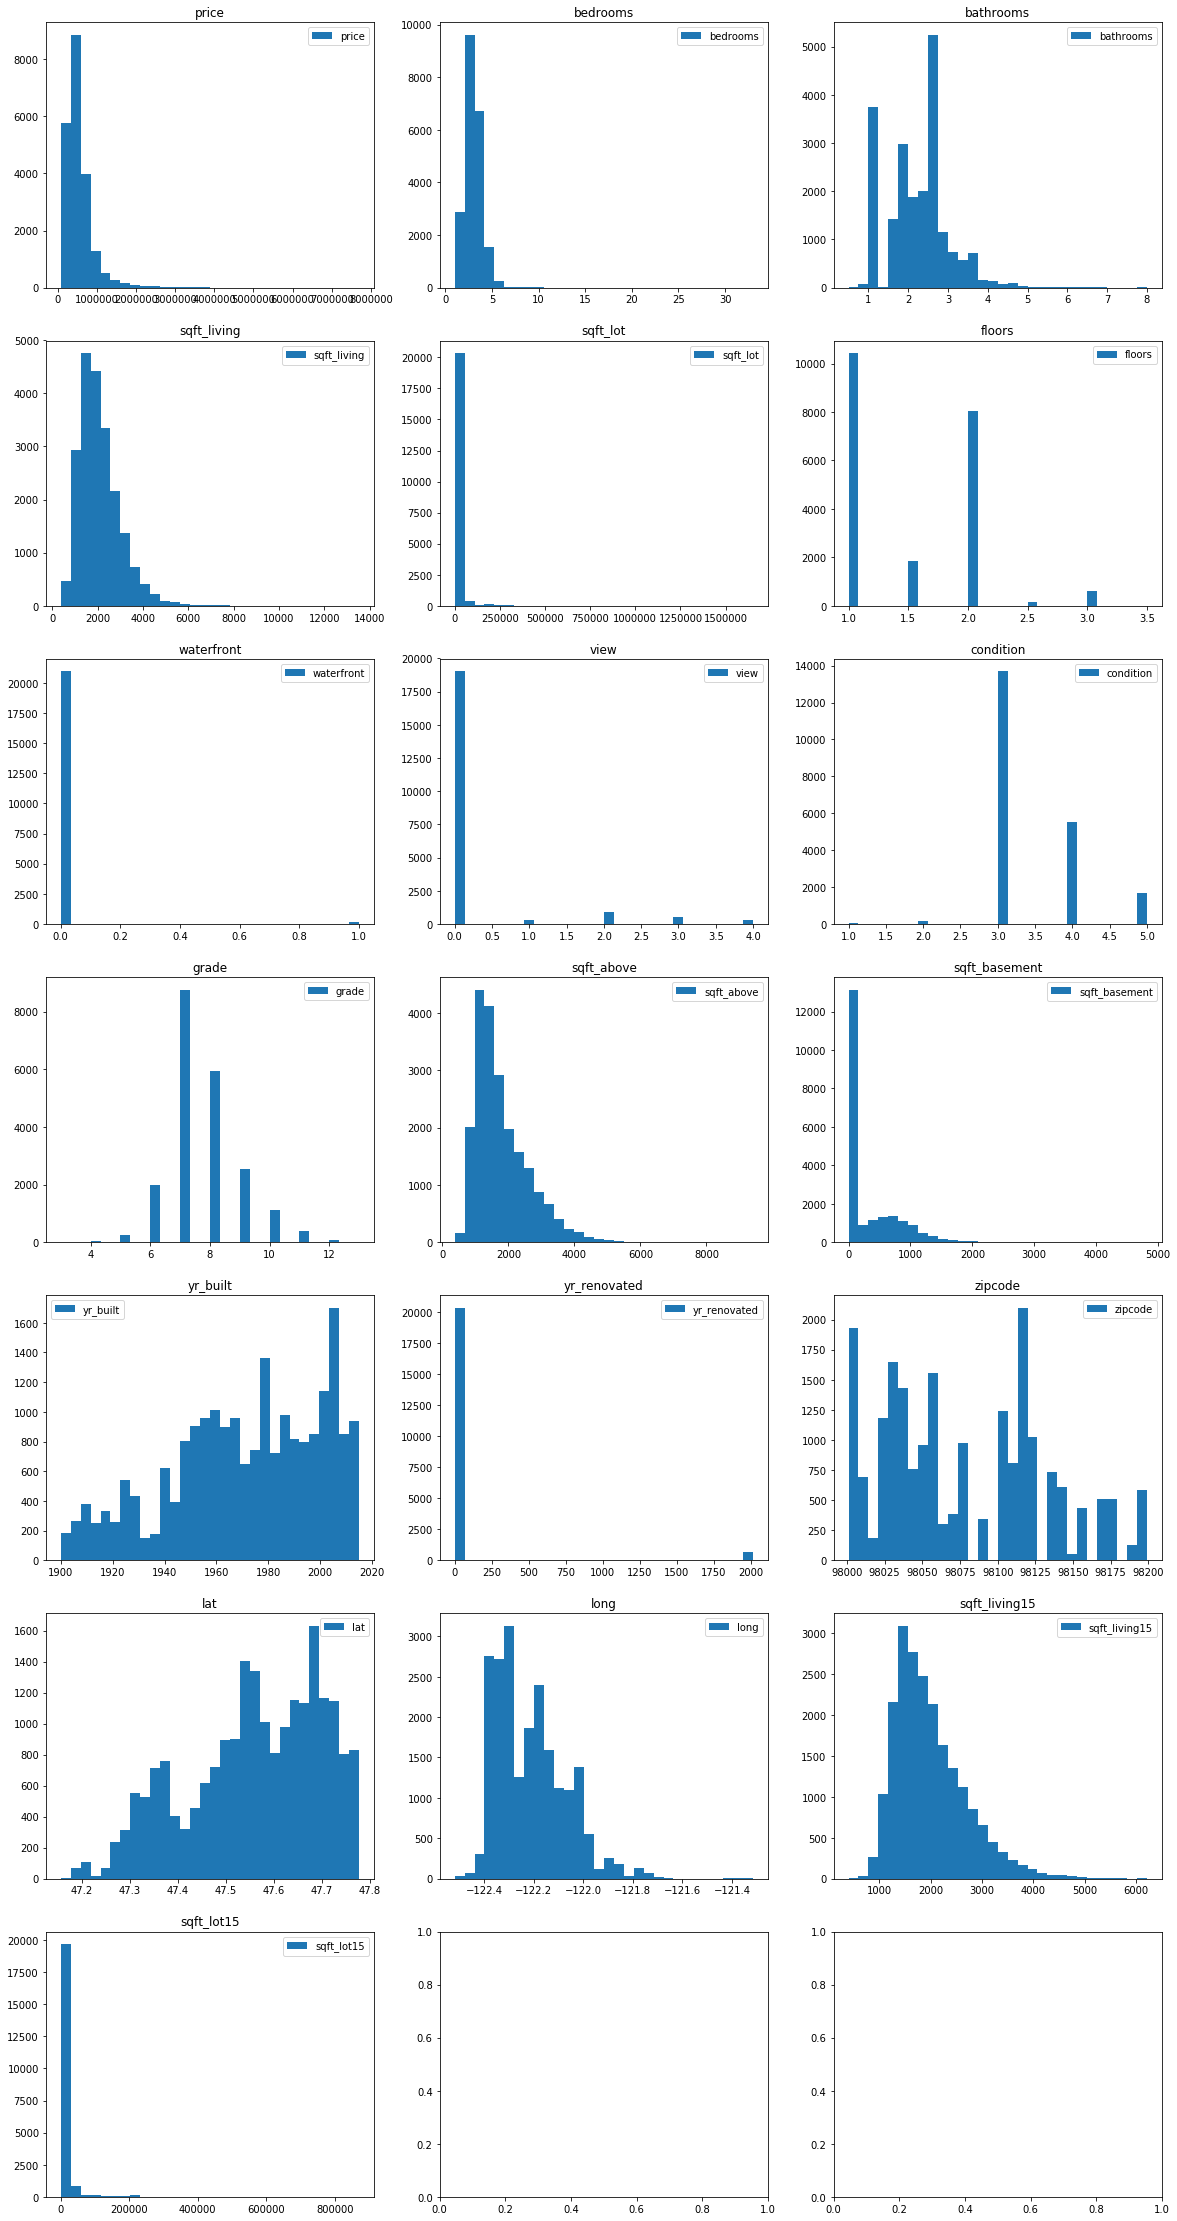

In [22]:
fig, axs = plt.subplots(7, 3, figsize=(20, 40))

for index, ax in enumerate(axs.flatten()):
# to avoid throwing an error, plug in the number of variables below
    if index < 19:   
        column = df_subset.columns[index]
        ax.hist(df_subset[column], bins=30)
        ax.set_title(column)
        ax.legend()
plt.show()

We can immediately discern a few important characteristics:
1. We seem to have several variables with possibly categorical data: *floors*, *waterfront*, *view*, *condition*, and *grade* for sure. Logically, *zipcode*, *bathrooms* and *bedrooms* would also be categorical, but it seems we may have an outlier in *bedrooms* and *floors*.
2. Heavily positively-skewed distribution: *price*, *bedrooms*, *sqft_living*, *sqft_above*, *sqft_living15*, *view*, *long*, *sqft_basement*
3. There is actually some negative skew for: *lat*, *yr_built*
4. somewhat normally distributed: *bathrooms*, *grade*

Let's go ahead and drop some of the obviously most extreme outliers from the *'sqft_'* family of variables.

In [23]:
# dropping sqft_living outliers
indexNames = df_subset[df_subset['sqft_living'] >= 5000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_above outliers
indexNames = df_subset[df_subset['sqft_living'] >= 4500 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_basement outliers
indexNames = df_subset[df_subset['sqft_basement'] >= 2000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers
indexNames = df_subset[df_subset['sqft_living'] >= 4500 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_lot outliers
indexNames = df_subset[df_subset['sqft_lot'] >= 100000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_lot15 outliers
indexNames = df_subset[df_subset['sqft_lot15'] >= 100000 ].index
df_subset.drop(indexNames , inplace=True)

#### Dropping Categorical Outliers

Now let's check out our potentially categorical variables more closely for outliers.

In [24]:
df_subset.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [25]:
cats = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode']
for cat in cats:
    print(df_subset[cat].value_counts(normalize=False))

3     9337
4     6405
2     2626
5     1401
6      221
1      185
7       25
8       10
9        5
10       2
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5095
1.00    3695
1.75    2910
2.25    1957
2.00    1833
1.50    1395
2.75    1120
3.00     691
3.50     624
3.25     499
3.75     122
4.00      88
0.75      70
4.50      56
4.25      33
1.25       9
5.00       7
4.75       5
5.25       4
0.50       3
7.50       1
6.00       1
5.75       1
Name: bathrooms, dtype: int64
1.0    10153
2.0     7573
1.5     1780
3.0      582
2.5      125
3.5        6
Name: floors, dtype: int64
0.0    20108
1.0      111
Name: waterfront, dtype: int64
0.0    18421
2.0      826
3.0      414
1.0      306
4.0      252
Name: view, dtype: int64
3    13083
4     5353
5     1606
2      150
1       27
Name: condition, dtype: int64
7     8612
8     5795
9     2403
6     1953
10     947
11     232
5      225
4       27
12      24
3        1
Name: grade, dtype: int64
98103    587
98115    564
98052    55

Wow, so it seems like most of these categories have some extreme outliers. We can probably drop any category that appears less than around 20 times. However, something funky appears to be going on with *bathrooms* and *floors*; we'll address them specifically in a moment.

In [26]:
# dropping grade outliers
indexNames = df_subset[df_subset['grade'] == 3 ].index
df_subset.drop(indexNames , inplace=True)
indexNames = df_subset[df_subset['grade'] == 13 ].index
df_subset.drop(indexNames , inplace=True)

# dropping bedroom outliers
indexNames = df_subset[df_subset['bedrooms'] >= 8 ].index
df_subset.drop(indexNames , inplace=True)

#### Dropping *price* outliers

We should also get rid of the crazy-expensive houses. Let's try keeping everything within 3 standard deviations of the mean (so as not to eliminate *too* much data.

In [27]:
print('mean = ', df_subset.price.mean())
print('std = ', df_subset.price.std())
up_lim = (df_subset.price.mean() + (3*df_subset.price.std()))
print('upper limit of our concern = ', up_lim)

mean =  515512.97876132483
std =  299502.5461764119
upper limit of our concern =  1414020.6172905606


In [28]:
# dropping price outliers based on our upper limit
indexNames = df_subset[df_subset['price'] > up_lim].index
df_subset.drop(indexNames , inplace=True)

### Taking a closer look at *floors* and *bathrooms*
We know that *floors* and *bathrooms* exhibit some weird chunkiness, but let's take a closer look at their distributions. 

Text(0.5, 1.0, 'bathrooms')

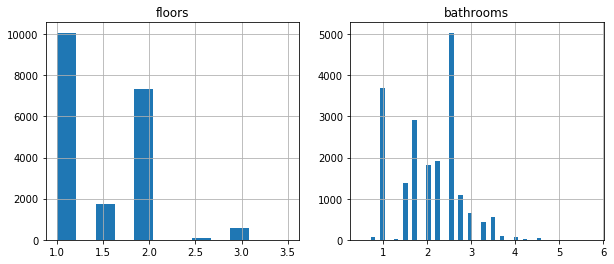

In [29]:
# plotting two histograms
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
df_subset.floors.hist(bins=12)
ax1.set_title("floors")

ax2 = plt.subplot(1,2,2)
df_subset.bathrooms.hist(bins=50)
ax2.set_title('bathrooms')

Gross. We need to clean that up a little bit.

Since there are a lot of half and quarter (just sinks? just toilets? just showers?) bathrooms, we'll just round every value down to an integer (1.75 intentionally rounds down to 1). It's just a hunch, but it seems like the number of full bathrooms might be more important than the number of partial bathrooms.

We'll go through a similar routine for *floors*, but this time we'll round everything up (1.5 rounds up to 2). Again, just a hunch, but this is based on the assumption that potential buyers would assign similar weights to both full- and half-flights of stairs.

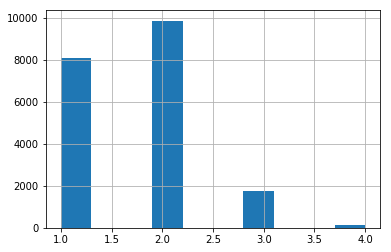

In [30]:
#grouping bathrooms
new_bath = []
for i in df_subset.bathrooms:
    if i >= 1:
        new_bath.append(math.trunc(i))
    else:
        new_bath.append(1)    
df_subset.bathrooms = new_bath

#now to group the outliers into the largest category
def impute_baths(value):
    if value > 4:
        return 4
    else:
        return value


df_subset.bathrooms = df_subset.bathrooms.map(lambda x: impute_baths(x))
df_subset.bathrooms.hist();

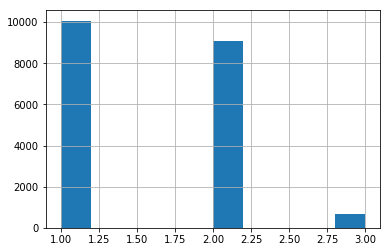

In [31]:
#grouping floors
new_floor = []
for i in df_subset.floors:
    new_floor.append(math.ceil(i))
df_subset.floors = new_floor

#now to group the outliers into the largest category
def impute_floors(value):
    if value > 3:
        return 3
    else:
        return value


df_subset.floors = df_subset.floors.map(lambda x: impute_floors(x))
df_subset.floors.hist();

Let's go ahead and drop those pesky outliers at the end of both groups.

In [32]:
# dropping bathrooms outliers
indexNames = df_subset[df_subset['bathrooms'] == 4 ].index
df_subset.drop(indexNames , inplace=True)
# dropping floors outliers
indexNames = df_subset[df_subset['floors'] == 3 ].index
df_subset.drop(indexNames , inplace=True)

### Double checking to make sure we got them all

To double check, let's graph the histograms again.

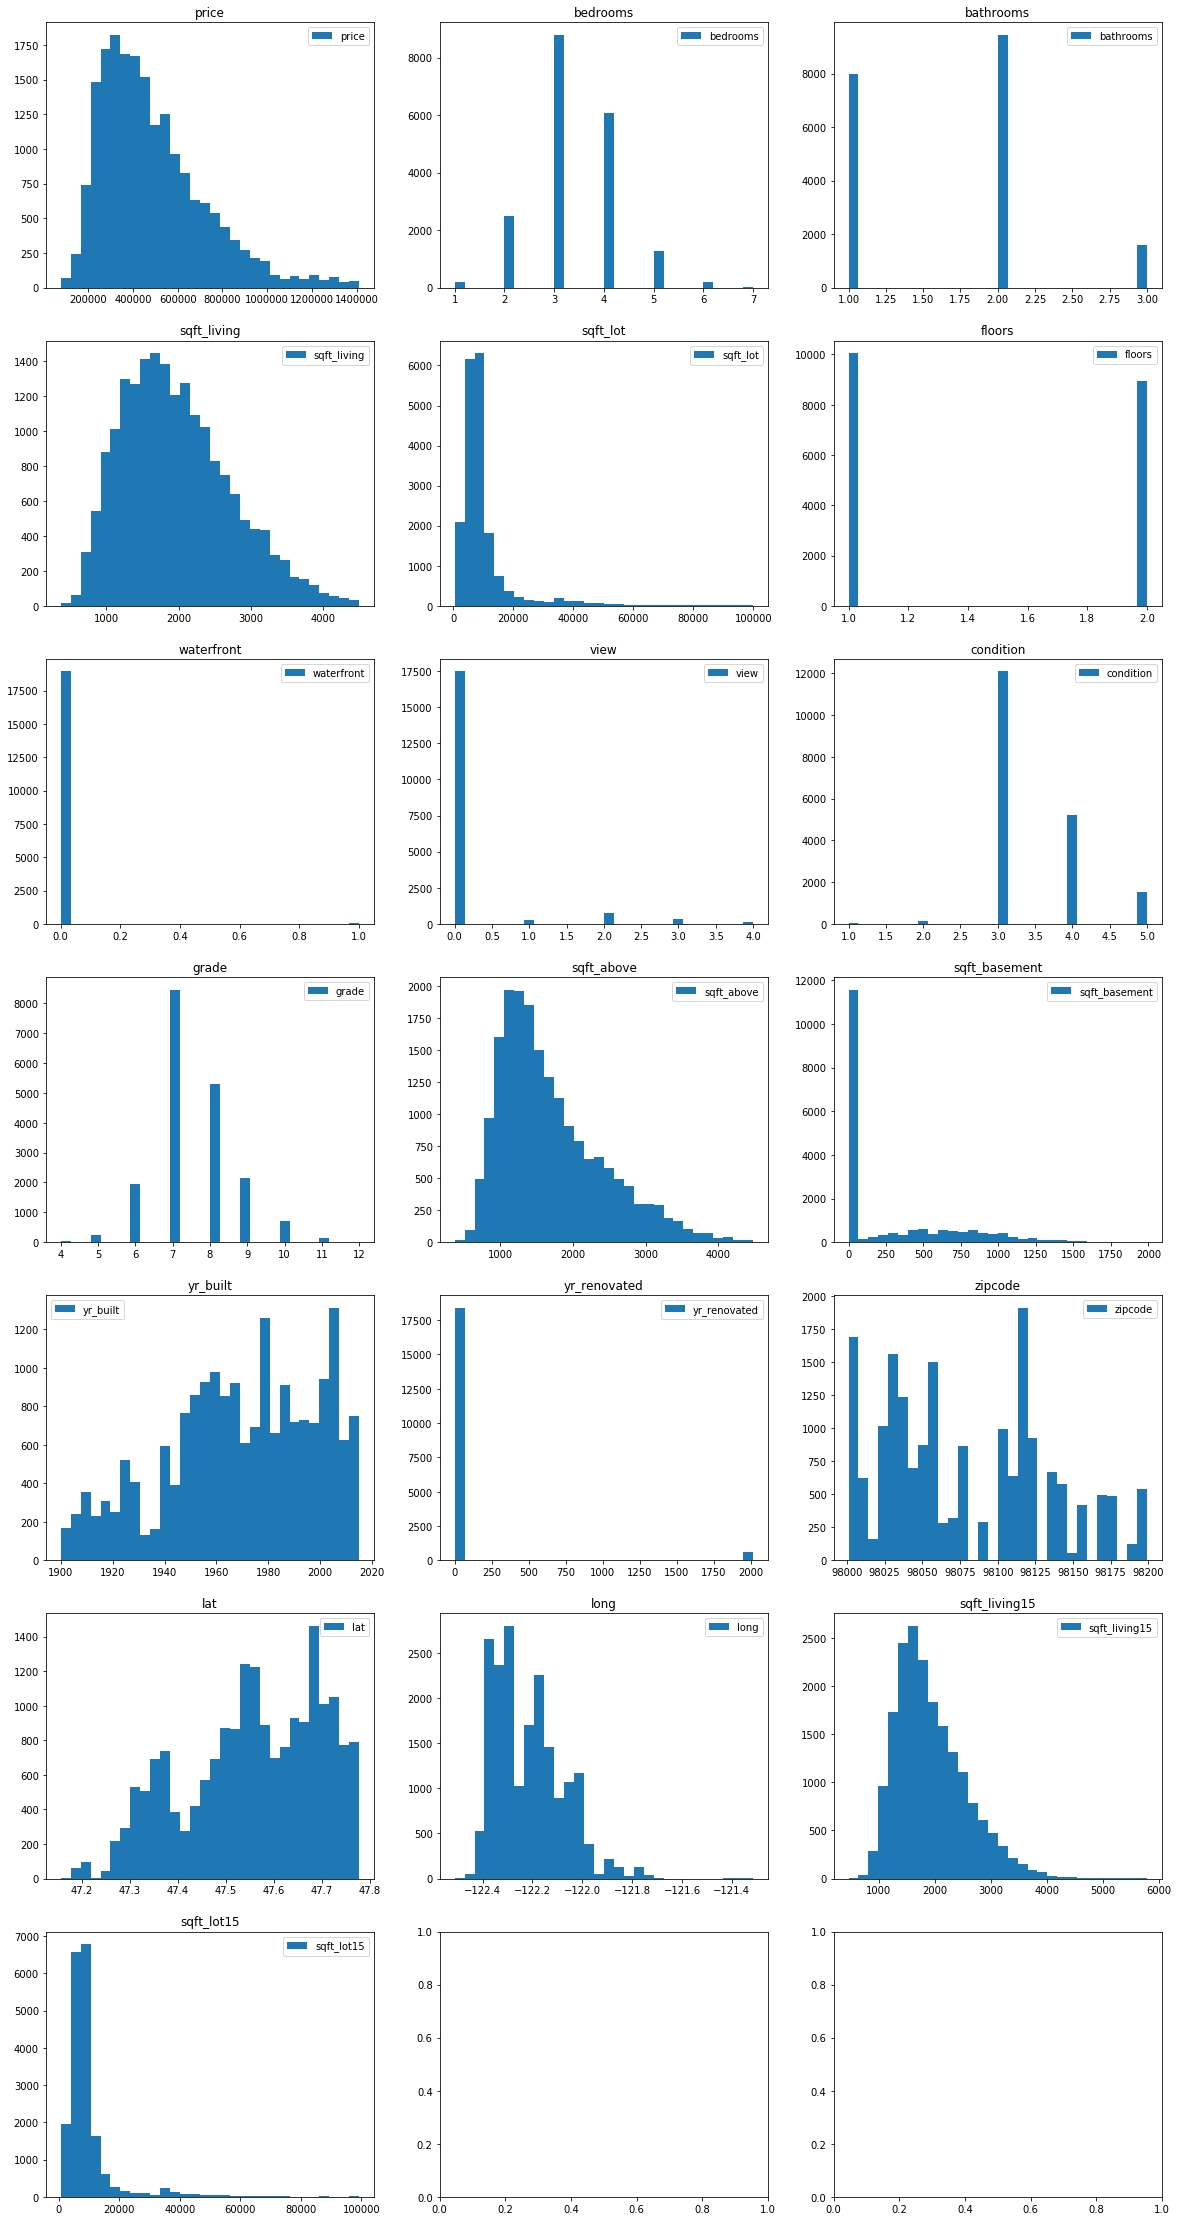

In [33]:
fig, axs = plt.subplots(7, 3, figsize=(20, 40))

for index, ax in enumerate(axs.flatten()):
    if index < 19:  # to avoid throwing an error
        column = df_subset.columns[index]
        ax.hist(df_subset[column], bins=30)
        ax.set_title(column)
        ax.legend()
plt.show()

That's a lot better, but there are still several which have extreme outliers. Now that our graphs are zoomed in we should be able to estimate a good cut-off point for these variables.

In [34]:
# dropping price outliers
indexNames = df_subset[df_subset['price'] >= 1000000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_above outliers
indexNames = df_subset[df_subset['sqft_above'] >= 4000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_basement outliers
indexNames = df_subset[df_subset['sqft_basement'] >= 1500 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_lot outliers
indexNames = df_subset[df_subset['sqft_lot'] >= 30000 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_living15 outliers
indexNames = df_subset[df_subset['sqft_living15'] >= 4250 ].index
df_subset.drop(indexNames , inplace=True)

# dropping sqft_lot15 outliers
indexNames = df_subset[df_subset['sqft_lot15'] >= 30000 ].index
df_subset.drop(indexNames , inplace=True)

# Exploratory Data Analysis (EDA) <a id='eda'></a>

## How can we reduce the number of variables in our model to something manageable?<a id='eda1'></a>

Now that we've cleaned our data to the best of our abilities, we need to start the process of selecting which variables are most relevant to our target variable (*price*). One easy way to start this process is by graphing a correlation heatmap that will visually display how correlated every variable is to each of the others.

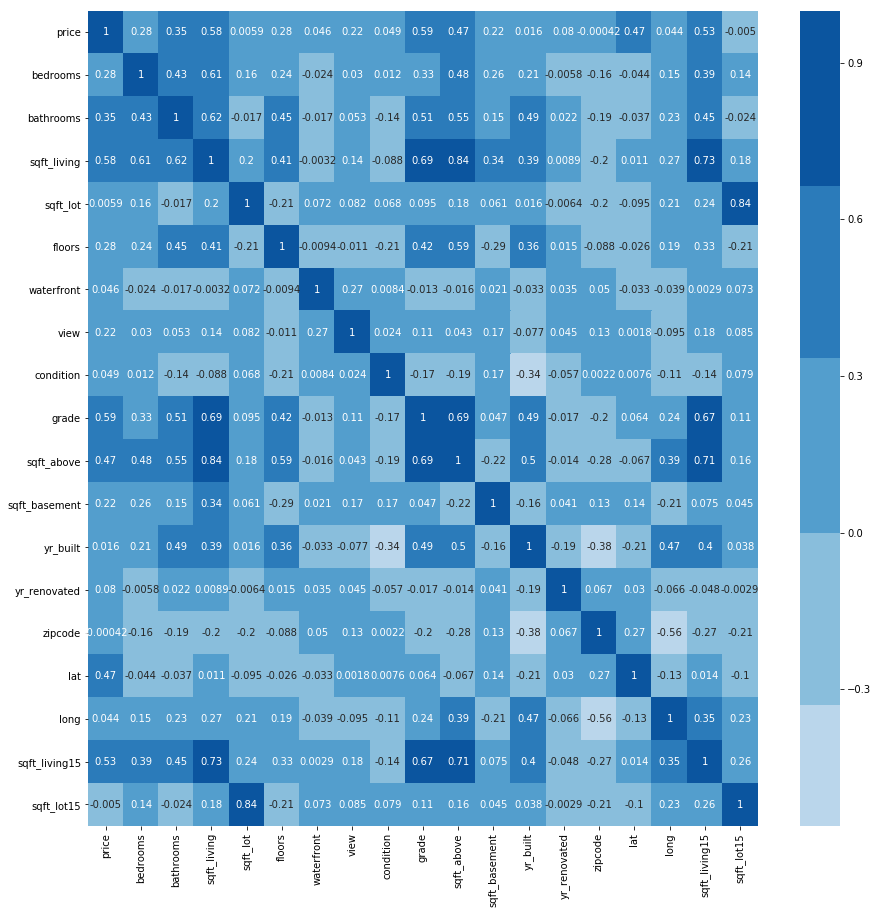

In [35]:
plt.figure(figsize=(15,15))
sns.heatmap(df_subset.corr(), annot=True, cmap=sns.color_palette('Blues'), center=0);

Alright, it looks like we have a lot of variables that are not well-correlated to *price*. Let's drop the ones that have a score lower than 0.1 (except *long* since it is paired with *lat*). Since these variables each account for less than a 10% change in the price of a house, we should be able to safely discard them without damaging our model too much. 

In [36]:
# dropping the least relevant variables
df_subset.drop(['sqft_lot','sqft_lot15','condition','yr_built','zipcode','waterfront','yr_renovated'], axis=1, inplace=True)

At this point, we might also be able to rule out some variable based on their **p-values**. Let's build a function that will iterate through 1:1 OLS regression models comparing ***price*** with each independent variable in turn.

In [37]:
# defining the function
def ols_iterate(y, x_list, dataset):
    """
    This function iterates through 1:1 OLS model summaries using
    an input target variable and a list of independent variables.
    --------------------
    y = target column name (ex: ['target'])
    x = list of DataFrame columns (ex: ['var1','var2','var3'])
    dataset = name of pd.DataFrame (ex: df)
    
    """
    listed = []
    for i in x_list:
        item = []
        x = dataset[i]
        X = sm.add_constant(x)
        linreg = sm.OLS(dataset[y], X).fit()
        item = [i, round(linreg.rsquared, 4), round(linreg.pvalues[1], 5)]
        listed.append(item)
    print('variable , r-squared , p-value')
    return listed

In [38]:
lerst = list(df_subset.columns)

In [39]:
ols_iterate('price', lerst, df_subset)

variable , r-squared , p-value


[['price', 1.0, 0.0],
 ['bedrooms', 0.0774, 0.0],
 ['bathrooms', 0.1216, 0.0],
 ['sqft_living', 0.3332, 0.0],
 ['floors', 0.0799, 0.0],
 ['view', 0.048, 0.0],
 ['grade', 0.3452, 0.0],
 ['sqft_above', 0.2201, 0.0],
 ['sqft_basement', 0.0501, 0.0],
 ['lat', 0.2243, 0.0],
 ['long', 0.0019, 0.0],
 ['sqft_living15', 0.2764, 0.0]]

Neat. It looks like all of our **p-values** are pretty solid, though certainly some variables have a higher correlation with ***price*** than others based on the **R-squared** scores.

Let's take a look at our correlation heatmap again to see what's going on now that we've removed some of the clutter.

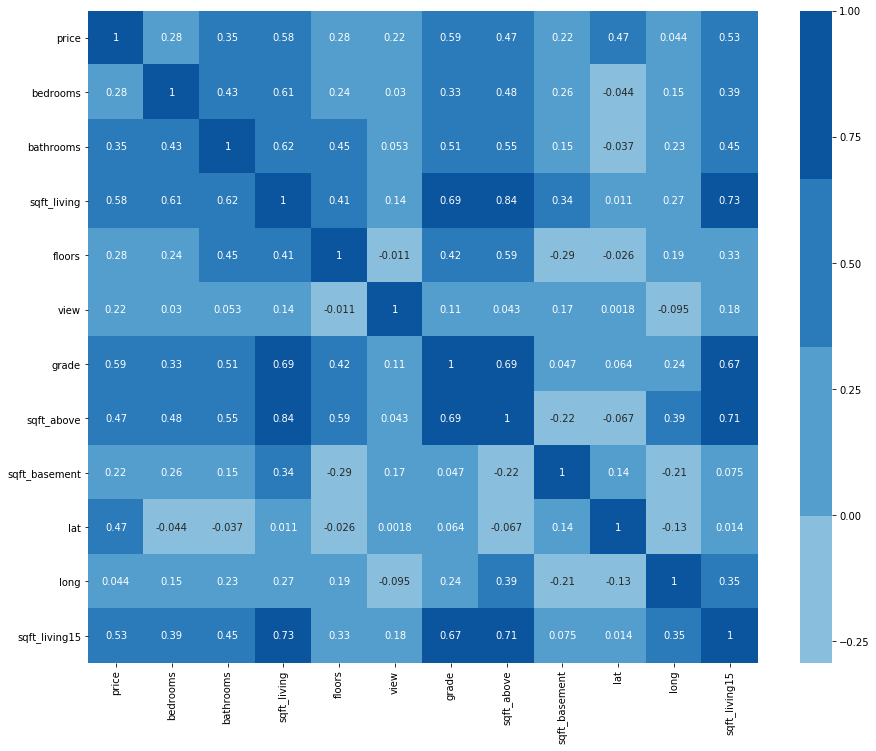

In [40]:
# cleaned up heatmap again
plt.figure(figsize=(15,12))
sns.heatmap(df_subset.corr(), annot=True, cmap=sns.color_palette('Blues'), center=0);

It looks like we have numerous candidates for multicolinearity based on the number of dark squares scattered throughout the heatmap. That's important to note for later when we want to start modeling, as we'll need to try to eliminate as much multicollinerity as possible.

Let's take a look at the scatter plots using a *scatter_matrix*. This graphing method should be useful for illumanting the shape of the pairwise relationships between our set of variables.

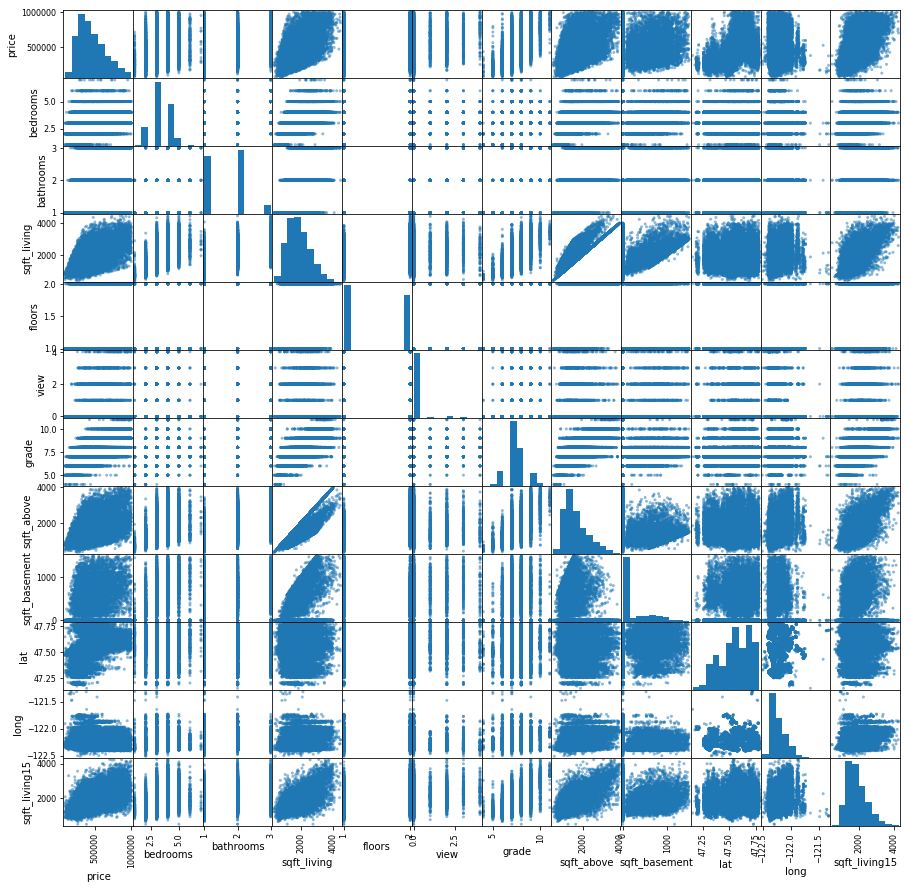

In [41]:
pd.plotting.scatter_matrix(df_subset, figsize=(15,15));

So much nicer! And it appears that half of our remaining variables may be categorical in nature, given the vertical/horizontal striations. 

Additionally, from these scatterplots, it looks like we have several candidates for linear relationships between ***price*** on the one hand and ***sqft_living***, ***grade***, ***sqft_above***, and ***sqft_living15*** on the other hand. However, the fact that most of those plots are more conical than linear in appearance is troubling. Perhaps we should address that in a moment. 

First, though, the bizarre graphs of ***lat*** and ***long*** should be addressed immediately.

## How might we handle geographical variables like *lat* & *long*?<a id='eda2'></a>

The scatterplots of ***lat*** and ***long*** above do not show any esaily discernible shape to them, suggesting that they may not actually play a direct role in house pricing (or at least not one that can be accounted for through a linear relationship). Let's take a closer look at their histograms to see if we can find any clues to what's going on.

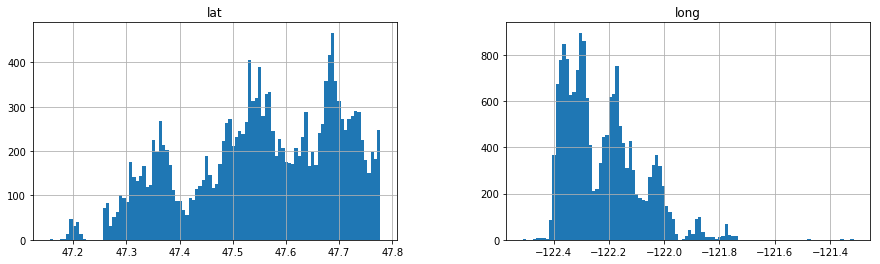

In [42]:
df_subset.hist(column=['lat','long'], bins=100, figsize=(15,4));

It looks like their might be some kind of highly-deformed normal distribution going on here, though the rolling hills appearance of the histograms makes that a questionable assertion at best. Perhaps we should utilize a different graphing technique to gain better understanding.

#### hexbins

Since we know that our ***lat*** & ***long*** data are simply map coordinates, a scatter plot of the two should look somewhat like the actual topography of the region where the data comes from. But scatterplots are boring. Let's try a **hexbin** that also uses house prices to determine the color of the plotted points.

To make sure we get a good look at the area, let's use the original dataset first so that we have as many datapoints as possible.

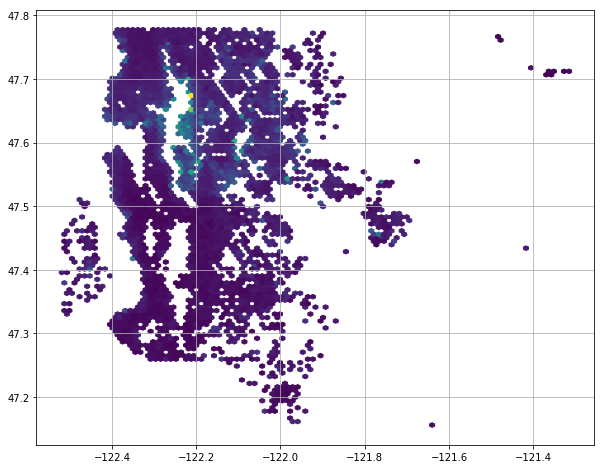

In [43]:
plt.figure(figsize=(10,8))
plt.grid()
plt.hexbin(df_orig.long, df_orig.lat, C=df_orig.price)
plt.show()

Hey! That looks like Seattle (just trust me on that)! A quick look at <a href="https://www.google.com/maps/@47.5285014,-122.3593406,10.36z" target="_blank" >Seattle on a map</a> shows that there are mountains, islands, and lakes scattered throughout this region. Furthermore, the white spaces in our graph line up perfectly with the bodies of water and mountainous regions on the map! That pretty well explains why the histograms were so erratic in nature. 

Unfortunately, there's no straightforward way to account for these intermittent data interruptions mathematically, but we can at least limit our model/dataset to the areas that are more densely populated (both in real life and in terms of data points on our graphs!). This is akin to removing outliers for geopositional data.

To do this, let's first hexbin graph our more refined data subset.

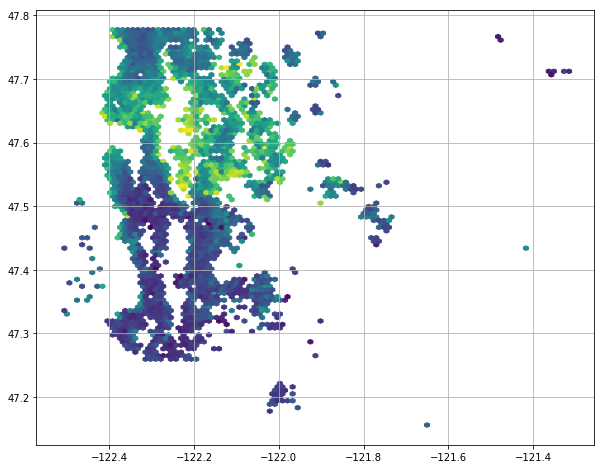

In [44]:
plt.figure(figsize=(10,8))
plt.grid()
plt.hexbin(df_subset.long, df_subset.lat, C=df_subset.price)
plt.show()

How about we cut out anything East of -122, anything West of -122.425, and anything South of 47.275. That won't make it perfect, but it should at least eliminate properties in the mountains or ones only accessible by ferries, producing a graph that displays a bit more even distribution.

In [45]:
# cutting off the Eastern suburbs and farmland
indexNames = df_subset[df_subset['long'] > -122 ].index
df_subset.drop(indexNames , inplace=True)

# cutting off the Western island
indexNames = df_subset[df_subset['long'] < -122.425 ].index
df_subset.drop(indexNames , inplace=True)

# cutting off the Southern end
indexNames = df_subset[df_subset['lat'] < 47.275 ].index
df_subset.drop(indexNames , inplace=True)

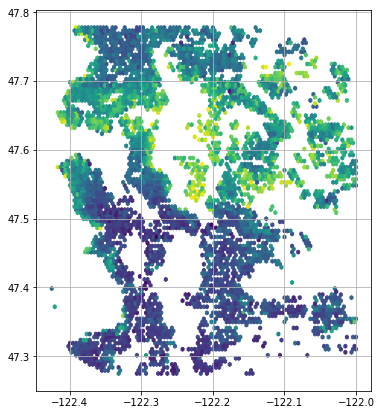

In [46]:
plt.figure(figsize=(6,7))
plt.grid()
plt.hexbin(df_subset.long, df_subset.lat, C=df_subset.price)
plt.show()

This looks better, but there's not much more that we can do with it without better observations. The *waterfront* variable would have been useful if half of the observations weren't missing. As such, we'll just have to refer realtors (or whoever is using this data) to this map to take it into account when looking at pricing of houses.

In [47]:
# We can also make our graphs look prettier now
plt.style.use('seaborn')

## Do we have any linear relationships?<a id='eda3'></a>

Since we've only learned about linear regressions so far, we'll hope that our variables are linearly related to **price**. Several of the scatter plots from above did have a noticeable oblong shape, though most were more conical than linear. Regardless, it's always best to double check whether a relationship is linear or not mathematically rather than just relying on a visual inspection.

One of the easiest ways to check for linearity is to check if it has a normal distribution. For variables in a large dataset this means doing a **Jarque-Bera test** and seeing what the *skew* and *kurtosis* scores are. Generally, a normal distribution has a skew < 1 and a kurtosis < 6. A low JB score (<6) corresponds to a normal distribution.

Since we have a lot of different variables still, we should probably write a function that will iterate through running this test for us in a pairwise fashion. 

In [48]:
def JB_iterate(y, x_list, dataset):
    """
    This function iterates through 1:1 OLS model summaries using
    an input target variable and a list of independent variables.
    --------------------
    y = target column name (ex: ['target'])
    x = list of DataFrame columns (ex: ['var1','var2','var3'])
    dataset = name of pd.DataFrame (ex: df)
    
    """
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    for i in x_list:
        f = str('price~'+i)
        model = smf.ols(formula=f, data=dataset).fit()
        test = sms.jarque_bera(model.resid)
        print(i,' : \n',list(zip(name, test)),'\n')
    pass

In [49]:
y = df_subset['price']
x = list(df_subset.drop('price', axis=1).columns)

JB_iterate(y, x, df_subset)

bedrooms  : 
 [('Jarque-Bera', 1048.1989548419124), ('Prob', 2.4349440568869994e-228), ('Skew', 0.6173288019678902), ('Kurtosis', 2.7548475647550115)] 

bathrooms  : 
 [('Jarque-Bera', 1068.5317649374422), ('Prob', 9.359989782649331e-233), ('Skew', 0.6280600133434131), ('Kurtosis', 2.8066684498726073)] 

sqft_living  : 
 [('Jarque-Bera', 619.463008594483), ('Prob', 3.0571504510406807e-135), ('Skew', 0.4788477717338087), ('Kurtosis', 2.861391629525836)] 

floors  : 
 [('Jarque-Bera', 1055.58692578388), ('Prob', 6.0563571967771e-230), ('Skew', 0.6220670977232673), ('Kurtosis', 2.781420430671564)] 

view  : 
 [('Jarque-Bera', 1198.2499676187588), ('Prob', 6.358073750544068e-261), ('Skew', 0.6692528509802472), ('Kurtosis', 2.8596368968326624)] 

grade  : 
 [('Jarque-Bera', 822.976703485386), ('Prob', 1.9628154630142137e-179), ('Skew', 0.5566540059684959), ('Kurtosis', 3.0676298385858964)] 

sqft_above  : 
 [('Jarque-Bera', 832.1020162780525), ('Prob', 2.0480614116728038e-181), ('Skew', 0.5

It would appear that none of our variables are normally distributed. These scores suggest that the residuals of each variable are rather positively-skewed and have heavy tails (most of the data are within 2.7-3.3 standard deviations of their mean). This means that we do *not* have any linear relationships just yet. We will need to do a little more manipulation.

### Normalizing, standardizing, scaling, etc.

We still need to tweak the variables with large values to make them a bit more manageable. Let's look at how correlated these variables might be, and then try a variety of standardization methods.

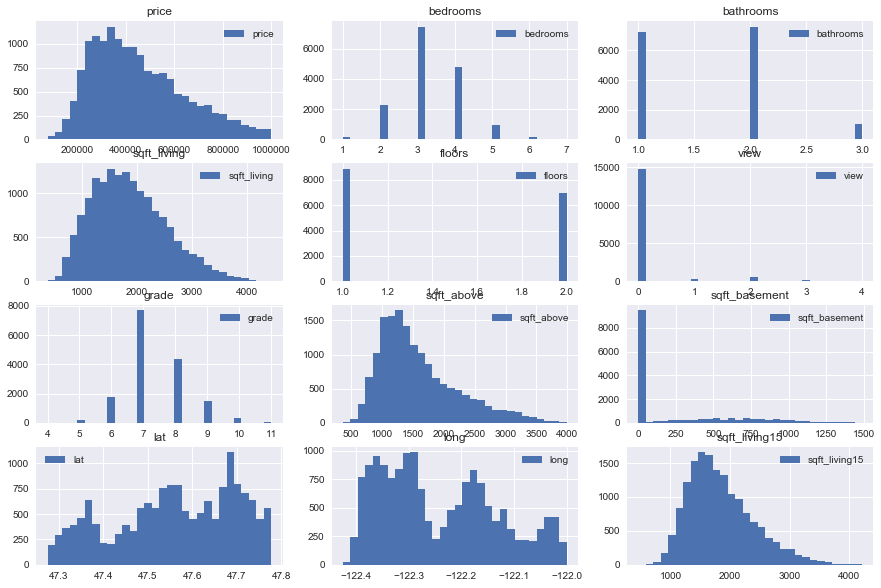

In [50]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for index, ax in enumerate(axs.flatten()):
    if index < 12:  # to avoid throwing an error
        column = df_subset.columns[index]
        ax.hist(df_subset[column], bins=30)
        ax.set_title(column)
        ax.legend()
plt.show()

We still have quite a few histograms that are positively-skewed. Let's run a few **log-transformations** to see if we can make some of them more normally-distributed. Let's try this on *sqft_living*, *sqft_above*, *sqft_living15*, and *bedrooms* since they appear to be just skewed normal distributions (hopefully!).

In [51]:
# creating a new DataFrame for log-transformations
df_sub_log = pd.DataFrame([])

# log-transforming the desired variables
df_sub_log['sqft_living'] = np.log(df_subset['sqft_living'])
df_sub_log['sqft_above'] = np.log(df_subset['sqft_above'])
df_sub_log['bedrooms'] = np.log(df_subset['bedrooms'])
df_sub_log['sqft_living15'] = np.log(df_subset['sqft_living15'])

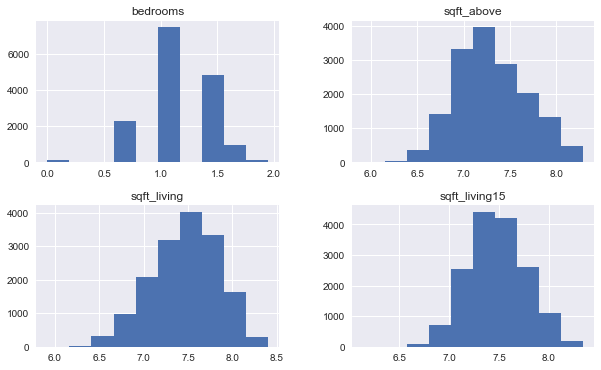

In [52]:
# plot the histograms to see if this had the desired result
df_sub_log.hist(figsize  = [10, 6]);

Good. Now let's standardize/scale many of the variables so that the units we're dealing with for each of them are all of a similar magnitude. 

Given their now-normal distribution, perhaps **mean normalization** would be worthwhile for the log-transformed ones. For things like *lat* and *long*, **min-max scaling** is likely to be more useful.

In [53]:
df_subset.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15'],
      dtype='object')

In [54]:
df_sub_log_scaled = pd.DataFrame([])
for column in df_sub_log.columns:
    G = df_sub_log[column]
    df_sub_log_scaled[column] = (G-np.mean(G)) / (max(G)-min(G))

# and doing the same for 'grade' since it already looked normal
G = df_subset['grade']
df_sub_log_scaled['grade'] = (G-np.mean(G)) / (max(G)-min(G))

# min-max scaling some other variables
G = df_subset['lat']
df_sub_log_scaled['lat'] = (G-min(G))/(max(G)-min(G))
G = df_subset['long']
df_sub_log_scaled['long'] = (G-min(G))/(max(G)-min(G))
G = df_subset['sqft_basement']
df_sub_log_scaled['sqft_basement'] = (G-min(G))/(max(G)-min(G))

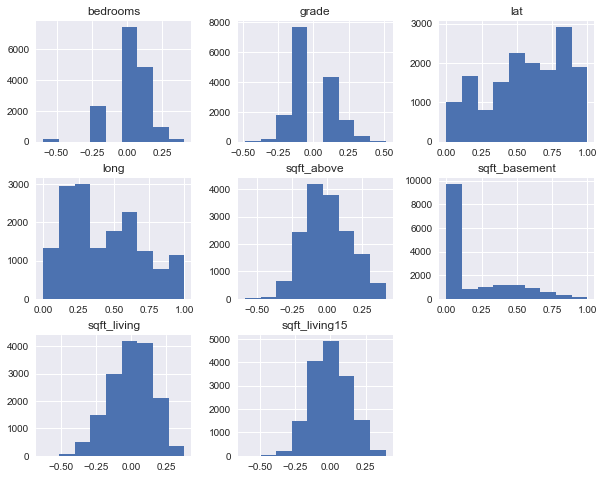

In [55]:
# display the histograms to double check results
df_sub_log_scaled.hist(bins=9, figsize  = [10, 8]);

Great! the x-axis for all of the variables are now all between -0.5 and 1, meaning they are all of a similar scale.

Now let's create a new DataFrame that combines these new values with the variables that did not undergo any transformations.

In [56]:
df_scaled = df_subset.copy()
for column in df_sub_log_scaled.columns:
    df_scaled[column] = df_sub_log_scaled[column]

Finally, we can build a linear regression model (using Ordinary Least Squares - OLS) to see what we're working with.

In [57]:
y = df_scaled['price']
x = df_scaled.drop(['price'], axis=1)
linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.159e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:20:17   Log-Likelihood:            -2.0870e+05
No. Observations:               15877   AIC:                         4.174e+05
Df Residuals:                   15866   BIC:                         4.175e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -5.764e+04   9147.466     -6.301      0.000   -7.56e+04   -3.97e+04
bathrooms      2.034e+04   2043.307      9.952      0.000    1.63e+04    2.43e+04
sqft_living   -6.672e+05   3.96e+04    -16.861      0.000   -7.45e+05    -5.9e+05
floors         8.311e+04   2202.586     37.733      0.000    7.88e+04    8.74e+04
view           4.332e+04   1803.548     24.020      0.000    3.98e+04    4.69e+04
grade          3.421e+05   1.09e+04     31.384      0.000    3.21e+05    3.63e+05
sqft_above     7.253e+05   3.59e+04     20.181      0.000    6.55e+05    7.96e+05
sqft_basement  3.837e+05   1.31e+04     29.189      0.000    3.58e+05    4.09e+05
lat            3.644e+05   3482.168    104.649      0.000    3.58e+05    3.71e+05
long            3.37e+04   4037.520      8.347      0.000    2.58e+04    4.16e+04
sqft_living15  1.912e+05   1.16e+04     16.523      0.000    1.69e+05    2.14e+05
==============================================================================
Omnibus:                      741.602   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1017.823
Skew:                           0.455   Prob(JB):                    9.60e-222
Kurtosis:                       3.842   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Those are pretty impressive scores for **adj-R-squared**, **F-statistic**, **skew**, **kurtosis**, **Jarque-Bera**, and **Condition Number** even though this is only the first time we've built a model of the data.

However, if you remember from the heatmaps above, we had a fair amount of multicollinearity which might be artificially inflating our scores. 

# Modeling<a id='modeling'></a>

## Now to start addressing multicollinearity!

Let's look at a heatmap again to determine where multicollinearities might exist.

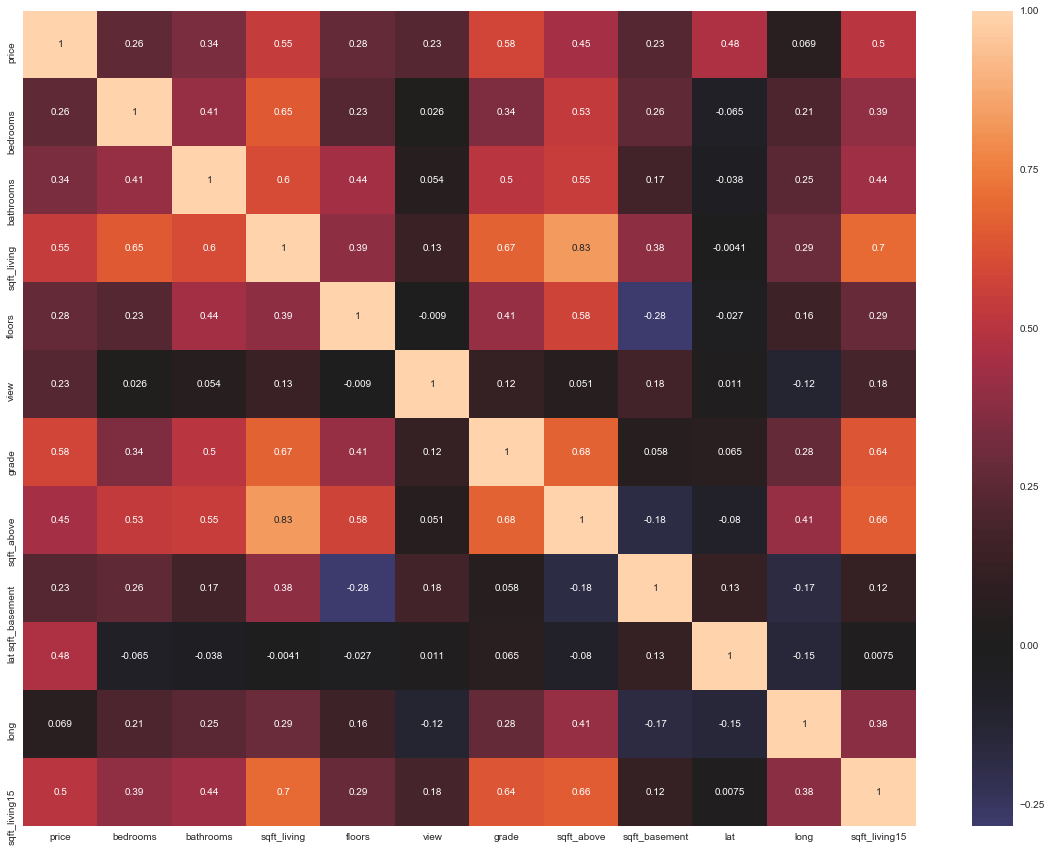

In [58]:
plt.figure(figsize=(20,15))
sns.heatmap(df_scaled.corr(), center=0, annot=True);

According to this heatmap, it looks like there are several variables with significant collinearities ( > 0.65):
1. ***sqft_living***: *grade*, *sqft_above*, *sqft_living15*, *bedrooms*, *bathrooms*

The variable *bathrooms* almost makes the threshold for entry into this group, so we'll just push it in to see what happens.
The variable *grade*, however, is really an unknown quantity (who knows what goes into it?), so we'll keep it separate for now.

Right off the bat, we can logically get rid of *sqft_living15* because most houses in a neighborhood will tend to be of similar sizes, so this presents an obvious collinearity. Therefore let's drop *sqft_living15* from our model.

In [59]:
df_scaled.drop(['sqft_living15'], axis=1, inplace=True)

Also, *grade* might be better suited as a categorical variable, so we'll not deal with it until later on.

So let's examine our continuous data first for potential collinearity. We can do this easily using a heatmap to display the pairwise correlation scores between the variables.

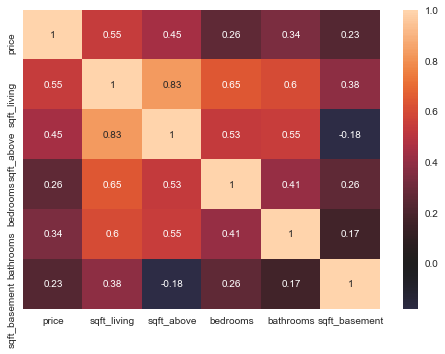

In [60]:
# slice just the variables we want to compare
df_sub_continuous = df_scaled[['price','sqft_living','sqft_above',
                               'bedrooms', 'bathrooms', 'sqft_basement']].copy()

# make a heatmap of the correlation
sns.heatmap(df_sub_continuous.corr(), center=0, annot=True);

It looks like they are all pretty heavily correlated, with the most interrelated appearing in the top left and becoming less related the further out we travel.

### Building a feature builder

Let's build a function that can take in two variables, a target ('price'), and a dataset to create a feature for our dataset, outputting a column of coefficients to our dataset for the new feature. This will allow us to easily make features whenever we want.

The output of this function should tell us the proportional influence upon price that any provided pair of variables might have. 

In [61]:
# building a feature building function. what fun!
def feature_builder(var_1, var_2, target, dataset):
    """
    Parameters :
    ------------
    var_1 : column name of first potentially correlated variable
    var_2 : column name of second potentially correlated variable
    target : column name of target variable
    dataset : name of pandas DataFrame that holds data and will receive updates
    
    
    """    
    weights = np.linspace(0, 1, 10000)
    max_corr = -1
    best_weights = None
    corrs = []
    
    for index, weight in enumerate(weights):
        w1 = weight # get the first weight value
        w2 = 1 - weight # get the second weight value
        vals = w1*dataset[var_1] + w2*dataset[var_2] # create a linear combination of the columns
        corr_coeff = np.abs(np.corrcoef(vals, dataset[target]))[0][1] # get the corrcoeff with the target
        
        # if the corr_coeff is larger than the max, store the weights and change the max
        if corr_coeff > max_corr:
            best_weights = [w1, w2]
            max_corr = corr_coeff
            
        # store the correlation coefficients to a list
        corrs.append(corr_coeff)  
        
    # output the desired weights
    print('weight for [',var_1,'] : weight for [',var_2,']\n', best_weights)
    feat_label = str(var_1+'_'+var_2+'_feature')
    print('feature name : ', feat_label)
    dataset[feat_label] = w1*dataset[var_1] + w2*dataset[var_2]
    return best_weights

In [62]:
# now to run the function on our small dataset
# we're saving this as a variable so we can recall it later if needed
wghts = feature_builder('sqft_living','sqft_above','price',df_sub_continuous)
wghts

weight for [ sqft_living ] : weight for [ sqft_above ]
 [1.0, 0.0]
feature name :  sqft_living_sqft_above_feature


[1.0, 0.0]

***Interesting!*** The feature builder suggests that we give all of the weight to *sqft_living*, essentially indicating that we can just drop *sqft_above* from our analysis altogether. Since we still have the *sqft_basement* variable, we haven't really lost much data here.

#### Evaluating our new feature

Now that we've created two potentially useful features, let's see how they might effect our model. To do so, we'll run three OLS models and compare their scores.

In [63]:
y = df_sub_continuous['price']

# original variables, untouched
x1 = df_sub_continuous[['sqft_living','sqft_above','bathrooms','bedrooms','sqft_basement']]

# our first custom feature with the remaining original continuous variables
x2 = df_sub_continuous[['sqft_living_sqft_above_feature','bathrooms','bedrooms','sqft_basement']]

# modeling and summarizing the first option (original)
linreg = sm.OLS(y, x1).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 1.917e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:20:47   Log-Likelihood:            -2.1520e+05
No. Observations:               15877   AIC:                         4.304e+05
Df Residuals:                   15872   BIC:                         4.305e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_living   -2.275e+06   5.13e+04    -44.362      0.000   -2.38e+06   -2.17e+06
sqft_above     2.383e+06   4.86e+04     49.053      0.000    2.29e+06    2.48e+06
bathrooms      1.574e+05   2048.238     76.849      0.000    1.53e+05    1.61e+05
bedrooms       -2.48e+05   1.35e+04    -18.405      0.000   -2.74e+05   -2.22e+05
sqft_basement  9.928e+05   1.78e+04     55.666      0.000    9.58e+05    1.03e+06
==============================================================================
Omnibus:                      245.925   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.625
Skew:                           0.304   Prob(JB):                     1.14e-56
Kurtosis:                       3.139   Cond. No.                         84.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# modeling and summarizing the second option
linreg = sm.OLS(y, x2).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 2.029e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:20:49   Log-Likelihood:            -2.1632e+05
No. Observations:               15877   AIC:                         4.327e+05
Df Residuals:                   15873   BIC:                         4.327e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
sqft_living_sqft_above_feature  1.553e+05   1.42e+04     10.936      0.000    1.27e+05    1.83e+05
bathrooms                       2.433e+05   1138.845    213.671      0.000    2.41e+05    2.46e+05
bedrooms                       -2.596e+05   1.45e+04    -17.951      0.000   -2.88e+05   -2.31e+05
sqft_basement                   1.687e+05   6421.443     26.265      0.000    1.56e+05    1.81e+05
==============================================================================
Omnibus:                      186.892   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.675
Skew:                           0.264   Prob(JB):                     8.79e-43
Kurtosis:                       3.122   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation

Looking at these summaries in sequence, it seems that the **F-statistic**, **Skew**, **Kurtosis**, and **Cond. No.** have all consistently improved as we progressed through this process. Our **R-squared** score has fallen a little bit, but that's to be expected when getting rid of multicollinearity. 

### Plugging this back into the larger dataset

In [65]:
df_scaled['sqft_living_sqft_above_feature'] = df_sub_continuous['sqft_living_sqft_above_feature']

# since we're about to remove columns, let's create a new DataFrame
df_sub_feats = df_scaled.copy()
df_sub_feats.drop(['sqft_living','sqft_above'], axis=1, inplace=True)
df_sub_feats.head()

,price,bedrooms,bathrooms,floors,view,grade,sqft_basement,lat,long,sqft_living_sqft_above_feature
index,,,,,,,,,,
0,221900.0,-0.028721,1,1,0.0,-0.057082,0.000000,0.469956,0.395294,-0.156976
1,538000.0,-0.028721,2,2,0.0,-0.057082,0.268456,0.887386,0.249412,0.155988
2,180000.0,-0.237089,1,1,0.0,-0.199939,0.000000,0.921011,0.451765,-0.328610
3,604000.0,0.119118,3,1,0.0,-0.057082,0.610738,0.489057,0.075294,0.047044
4,510000.0,-0.028721,2,1,0.0,0.085775,0.000000,0.680064,0.894118,-0.014935


In [66]:
y = df_sub_feats['price']
x = df_sub_feats.drop(['price'], axis=1)

linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 2.522e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:20:56   Log-Likelihood:            -2.0904e+05
No. Observations:               15877   AIC:                         4.181e+05
Df Residuals:                   15868   BIC:                         4.182e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
bedrooms                       -6.399e+04   9324.986     -6.862      0.000   -8.23e+04   -4.57e+04
bathrooms                       2.861e+04   2040.884     14.018      0.000    2.46e+04    3.26e+04
floors                          9.049e+04   2154.016     42.012      0.000    8.63e+04    9.47e+04
view                            5.323e+04   1798.704     29.592      0.000    4.97e+04    5.68e+04
grade                           3.852e+05   1.08e+04     35.813      0.000    3.64e+05    4.06e+05
sqft_basement                   1.248e+05   4848.016     25.748      0.000    1.15e+05    1.34e+05
lat                             3.758e+05   3524.435    106.613      0.000    3.69e+05    3.83e+05
long                            6.572e+04   3924.762     16.745      0.000     5.8e+04    7.34e+04
sqft_living_sqft_above_feature  1.825e+05   1.23e+04     14.797      0.000    1.58e+05    2.07e+05
==============================================================================
Omnibus:                      874.048   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1205.022
Skew:                           0.511   Prob(JB):                    2.15e-262
Kurtosis:                       3.882   Cond. No.                         37.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Looks like we're still doing pretty good!

## Feature Selection

Let's use several feature selection tools in a row to hone and refine our model. Let's begin with **stepwise selection** and then proceed to **feature ranking with recursive elimination** to see which other features we should keep from our dataset.

In [67]:
# code provided by Section 8 lesson

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [68]:
# now run our dataset through the function
y = df_sub_feats['price']
x = df_sub_feats.drop(['price'], axis=1)

result = stepwise_selection(x, y, verbose = True)
print('resulting features:')
print(result)

Add  bathrooms                      with p-value 0.0
Add  sqft_living_sqft_above_feature with p-value 0.0
Add  lat                            with p-value 0.0
Add  grade                          with p-value 0.0
Drop bathrooms                      with p-value 0.379646
Add  view                           with p-value 8.2508e-174
Add  floors                         with p-value 2.26474e-18


C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  bedrooms                       with p-value 2.8026e-14
Add  sqft_basement                  with p-value 1.10351e-10
Add  long                           with p-value 0.000116229
resulting features:
['sqft_living_sqft_above_feature', 'lat', 'grade', 'view', 'floors', 'bedrooms', 'sqft_basement', 'long']


***So*** this process asks us to eliminate *bathrooms*. That's fine. Let's see what OLS says without it.

In [69]:
df_stepped = df_sub_feats.copy()
df_stepped.drop('bathrooms', axis=1, inplace=True)

In [70]:
y = df_stepped['price']
x = df_stepped.drop(['price'], axis=1)

linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 2.800e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:21:43   Log-Likelihood:            -2.0914e+05
No. Observations:               15877   AIC:                         4.183e+05
Df Residuals:                   15869   BIC:                         4.184e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
bedrooms                       -5.564e+04   9363.088     -5.942      0.000    -7.4e+04   -3.73e+04
floors                          1.111e+05   1582.630     70.214      0.000    1.08e+05    1.14e+05
view                            5.382e+04   1809.246     29.748      0.000    5.03e+04    5.74e+04
grade                            3.98e+05   1.08e+04     36.915      0.000    3.77e+05    4.19e+05
sqft_basement                   1.496e+05   4542.994     32.923      0.000    1.41e+05    1.58e+05
lat                             3.811e+05   3525.412    108.094      0.000    3.74e+05    3.88e+05
long                            8.386e+04   3728.063     22.494      0.000    7.66e+04    9.12e+04
sqft_living_sqft_above_feature  1.876e+05   1.24e+04     15.123      0.000    1.63e+05    2.12e+05
==============================================================================
Omnibus:                      806.077   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.706
Skew:                           0.484   Prob(JB):                    7.92e-241
Kurtosis:                       3.858   Cond. No.                         26.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Not bad; there were only modest improvements in a few scores, but no scores got worse. Thus, we are safe to eliminate *bathrooms* from our model.

Now let's try out **feature ranking with recursive elimination** to see if we can tighten things up a little bit. 

In [71]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE

y = df_stepped['price']
x = df_stepped.drop(['price'], axis=1)

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 6)
selector = selector.fit(x, y)

In [72]:
selector.support_

array([ True, False,  True,  True,  True,  True, False,  True])

In [73]:
selector.ranking_

array([1, 2, 1, 1, 1, 1, 3, 1])

In [74]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[-67460.54431242  46570.86290581 452471.07523762   6924.85607912
 320374.46526538 440788.22154229]
265142.9885279387


In [75]:
feats_array = np.array(x.columns)
zipped = set(zip(selector.ranking_, feats_array))
feats = []
for i, name in zipped:
    if i==1:
        feats.append(name)

feats

['view',
 'sqft_living_sqft_above_feature',
 'sqft_basement',
 'bedrooms',
 'lat',
 'grade']

In [76]:
df_elim = df_stepped[['price','lat', 'view', 'grade', 'sqft_basement',
                      'sqft_living_sqft_above_feature', 'bedrooms']].copy()

In [77]:
y = df_elim['price']
x = df_elim.drop(['price'], axis=1)

linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 2.147e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:22:04   Log-Likelihood:            -2.1315e+05
No. Observations:               15877   AIC:                         4.263e+05
Df Residuals:                   15871   BIC:                         4.264e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lat                             6.737e+05   2637.303    255.452      0.000    6.69e+05    6.79e+05
view                            6.142e+04   2315.241     26.530      0.000    5.69e+04     6.6e+04
grade                           4.338e+05   1.39e+04     31.258      0.000    4.07e+05    4.61e+05
sqft_basement                   9.178e+04   5803.084     15.816      0.000    8.04e+04    1.03e+05
sqft_living_sqft_above_feature  3.473e+05   1.58e+04     21.914      0.000    3.16e+05    3.78e+05
bedrooms                        4144.9337    1.2e+04      0.345      0.730   -1.94e+04    2.77e+04
==============================================================================
Omnibus:                      357.291   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.304
Skew:                          -0.378   Prob(JB):                     1.59e-83
Kurtosis:                       3.076   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Still improving according to all of our metrics (except R-squared, of course). 

But hold on, it looks like the **p-value** for *bedrooms* is now terrible! It looks like *bedrooms* and *bathrooms* must have depended heavily upon each other in terms of their relevance to house pricing. Now that one of them is gone it looks like we can safely remove the other. 

In [78]:
df_elim.drop('bedrooms', axis=1, inplace=True)

Let's check out that correlation heatmap once again to see how much multicollinearity is remaining.

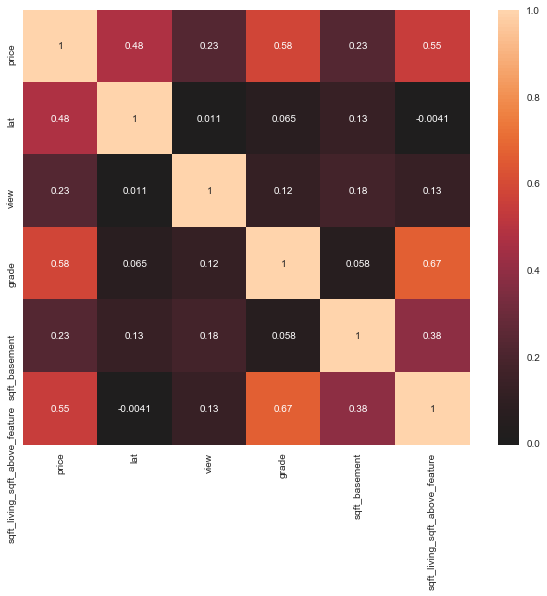

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(df_elim.corr(), center=0, annot=True);

### Can we build a super-feature?

We've apparently still got some degree of multicollinearity between our custom feature, *grade*, and *bedrooms*; let's see what happens if we build a custom super-feature, comparing the iterations throughout the building process.

In [80]:
super_feat = df_elim.copy()

In [81]:
super_feat.columns

Index(['price', 'lat', 'view', 'grade', 'sqft_basement',
       'sqft_living_sqft_above_feature'],
      dtype='object')

In [82]:
# we are saving this as a variable so it can be recalled later
wghts2 = feature_builder('grade','sqft_living_sqft_above_feature', 'price', super_feat)
wghts2

weight for [ grade ] : weight for [ sqft_living_sqft_above_feature ]
 [0.5991599159915992, 0.40084008400840077]
feature name :  grade_sqft_living_sqft_above_feature_feature


[0.5991599159915992, 0.40084008400840077]

In [83]:
y = super_feat['price']

# no changes
x1 = super_feat[['lat', 'sqft_basement', 'view', 'sqft_living_sqft_above_feature', 'grade']]

# super-feature
x2 = super_feat[['lat', 'sqft_basement', 'view', 'grade_sqft_living_sqft_above_feature_feature']]


linreg = sm.OLS(y, x1).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 2.576e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:22:25   Log-Likelihood:            -2.1315e+05
No. Observations:               15877   AIC:                         4.263e+05
Df Residuals:                   15872   BIC:                         4.264e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
lat                             6.737e+05   2637.065    255.472      0.000    6.69e+05    6.79e+05
sqft_basement                   9.178e+04   5802.923     15.817      0.000    8.04e+04    1.03e+05
view                            6.137e+04   2310.231     26.565      0.000    5.68e+04    6.59e+04
sqft_living_sqft_above_feature  3.503e+05   1.32e+04     26.522      0.000    3.24e+05    3.76e+05
grade                           4.331e+05   1.37e+04     31.558      0.000    4.06e+05     4.6e+05
==============================================================================
Omnibus:                      356.855   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              380.810
Skew:                          -0.377   Prob(JB):                     2.03e-83
Kurtosis:                       3.075   Cond. No.                         9.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
linreg = sm.OLS(y, x2).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.067e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:22:26   Log-Likelihood:            -2.1350e+05
No. Observations:               15877   AIC:                         4.270e+05
Df Residuals:                   15873   BIC:                         4.270e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
lat                                           6.517e+05   2557.555    254.798      0.000    6.47e+05    6.57e+05
sqft_basement                                 1.651e+05   5214.250     31.659      0.000    1.55e+05    1.75e+05
view                                           6.04e+04   2360.498     25.588      0.000    5.58e+04     6.5e+04
grade_sqft_living_sqft_above_feature_feature   6.91e+05   9893.180     69.845      0.000    6.72e+05     7.1e+05
==============================================================================
Omnibus:                      198.032   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.268
Skew:                          -0.278   Prob(JB):                     2.67e-45
Kurtosis:                       2.958   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Wow! Our **skew** and **kurtosis** increased slightly, but it is still well within the acceptable range. Our **R-squared** fell by 0.07, which is better than expected. But more importantly, our **Condition Number** score (and therefore degree of multicollinearity) improved quite a bit. Let's look at the correlation heatmap to double check visually for having removed multicollinearity.

In [85]:
# We may as well rename our superfeature something easy
super_feat.rename(columns={'grade_sqft_living_sqft_above_feature_feature':'super_feature'}, inplace=True)

In [86]:
super_feat.drop(['grade', 'sqft_living_sqft_above_feature'], axis=1, inplace=True)

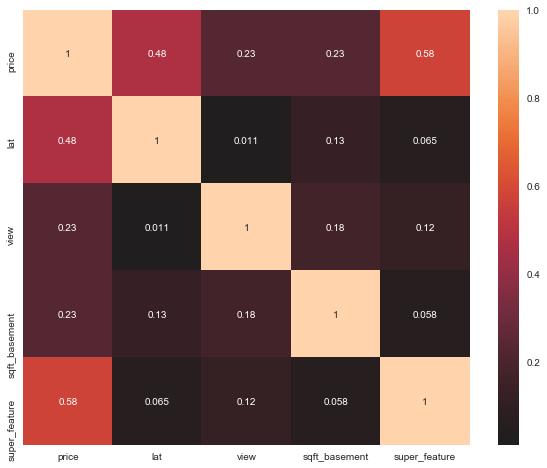

In [87]:
plt.figure(figsize=(10,8))
sns.heatmap(super_feat.corr(), center=0, annot=True);

## Pricing Equation

Now that we're done tinkering with things, let's state what our pricing equation is at the moment. Afterwards, we'll move on to validating our model as a legitimate (and hopefully useful) tool. 

Before we produce our pricing equation, we must remember that we manipulated most of the independent variables in some way. Thus, we need to reverse engineer those manipulations so that we can produce an equation capable have handling real world (un-manipulated) inputs.

Remember, we:
- **log-transformed** and then **mean-normalized** *sqft_living*
- **mean-normalized** *grade*
- **min-max scaled** both *lat* and *sqft_basement*

Let's recall the relevant statistical measures:

In [88]:
print('log_sqft_living mean = ',np.mean(df_sub_log.sqft_living))
print('log_sqft_living max = ',np.max(df_sub_log.sqft_living))
print('log_sqft_living max = ',np.mean(df_sub_log.sqft_living),'\n')

print('grade mean = ',np.mean(df_subset.grade))
print('grade max = ',np.max(df_subset.grade))
print('grade max = ',np.mean(df_subset.grade),'\n')

print('lat max = ',np.max(df_subset.lat))
print('lat max = ',np.mean(df_subset.lat),'\n')

print('sqft_basement max = ',np.max(df_subset.sqft_basement))
print('sqft_basement max = ',np.mean(df_subset.sqft_basement),'\n')

log_sqft_living mean =  7.463694524538544
log_sqft_living max =  8.400659375160286
log_sqft_living max =  7.463694524538544 

grade mean =  7.399571707501417
grade max =  11
grade max =  7.399571707501417 

lat max =  47.7776
lat max =  47.56126055929962 

sqft_basement max =  1490
sqft_basement max =  268.7017698557662 



So, to un-scale *lat* and *sqft_basement*, we just need to reverse the formula $\frac {x - min(x)}{max(x) - min(x)}$

To un-normalize *grade* and the log of *sqft_living*, we need to reverse the formula $\frac {x - mean(x)}{max(x) - min(x)}$

In [89]:
# running OLS to produce the coefficients which need to be un-transformed
y = super_feat.price
x = super_feat.drop('price', axis=1)
linreg = sm.OLS(y, x).fit()
print(linreg.params)
print('\nweights for grade and sqft_living : ',wghts2,'\n')


# let's automate this process to give us the true coefficients
# for unmanipulated data (so we can plug in test values later if we want)
coef_lat = ((linreg.params['lat'] / 
                       (np.max(df_subset.lat) - np.min(df_subset.lat))))
coef_sqft_basement = ((linreg.params['sqft_basement'] / 
             (np.max(df_subset.sqft_basement) - np.min(df_subset.sqft_basement))))
coef_grade = ((linreg.params['super_feature'] * wghts2[0]) / 
              (np.max(df_subset.grade) - np.min(df_subset.grade)))
# coef_sqft_living = ((np.e**((linreg.params['super_feature'] * wghts2[1]) / 
#                             (np.max(df_sub_log.sqft_living) - np.min(df_sub_log.sqft_living)))))
coef_sqft_living = ((linreg.params['super_feature'] * wghts2[1]) / 
                            (np.max(df_sub_log.sqft_living) - np.min(df_sub_log.sqft_living)))
constant = (-1 * (((linreg.params['lat'] * np.min(df_subset.lat)) / (np.max(df_subset.lat) - np.min(df_subset.lat))) +
                     ((linreg.params['sqft_basement'] * np.min(df_subset.sqft_basement)) / 
                      (np.max(df_subset.sqft_basement) - np.min(df_subset.sqft_basement))) +
                     ((linreg.params['super_feature'] * wghts2[0]) * np.mean(df_subset.grade) / 
                      (np.max(df_subset.grade) - np.min(df_subset.grade))) +
                     ((linreg.params['super_feature'] * wghts2[1]) * np.mean(df_sub_log.sqft_living) /
                      (np.max(df_sub_log.sqft_living) - np.min(df_sub_log.sqft_living)))
                    )
           )


# and printing them out
print('coefficient for sqft_basement : ', coef_sqft_basement)
print('coefficient for lat : ', coef_lat)
print('coefficient for grade : ', coef_grade)
print('coefficient for sqft_living : ', coef_sqft_living)
print('constant : ', constant)

lat              651660.918596
view              60401.318113
sqft_basement    165079.981708
super_feature    690987.467471
dtype: float64

weights for grade and sqft_living :  [0.5991599159915992, 0.40084008400840077] 

coefficient for sqft_basement :  110.79193403240232
coefficient for lat :  1296579.6231506981
coefficient for grade :  59144.57042302023
coefficient for sqft_living :  111362.308338915
constant :  -62564620.42539289


In [90]:
df[['price','sqft_basement','lat','grade','sqft_living']].head()

,price,sqft_basement,lat,grade,sqft_living
index,,,,,
0,221900.0,0.0,47.5112,7,1180
1,538000.0,400.0,47.7210,7,2570
2,180000.0,0.0,47.7379,6,770
3,604000.0,910.0,47.5208,7,1960
4,510000.0,0.0,47.6168,8,1680


Let's test it with the second item in our original dataset (see table above).

In [91]:
price_est = ((coef_sqft_basement*400) + (47.7210*coef_lat) + (coef_grade*7) + (coef_sqft_living*(np.log(2570))) + (constant))
print('price estimate : $', price_est)

price estimate : $ 642163.650620468


Pretty good!

So, using this information, we can now construct our full price equation:

$$p = (1296579.6 \times f_L) + (60401.32 \times f_V) + (110.79 \times f_B) + (59144.57 \times f_G) + (111362.3 \times log_e(f_S)) - 62564620.4$$

$p =$ House price (in USD)

$f_L =$ latitude

$f_V =$ times property has been viewed

$f_B =$ square footage of basement

$f_G =$ grade given to the housing unit, based on King County grading system

$f_S =$ square footage of living space

And just for smiles, here's our final OLS output from Statsmodels:

In [92]:
y = super_feat.price
x = super_feat.drop('price', axis=1)
linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.067e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:22:54   Log-Likelihood:            -2.1350e+05
No. Observations:               15877   AIC:                         4.270e+05
Df Residuals:                   15873   BIC:                         4.270e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
lat            6.517e+05   2557.555    254.798      0.000    6.47e+05    6.57e+05
view            6.04e+04   2360.498     25.588      0.000    5.58e+04     6.5e+04
sqft_basement  1.651e+05   5214.250     31.659      0.000    1.55e+05    1.75e+05
super_feature   6.91e+05   9893.180     69.845      0.000    6.72e+05     7.1e+05
==============================================================================
Omnibus:                      198.032   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.268
Skew:                          -0.278   Prob(JB):                     2.67e-45
Kurtosis:                       2.958   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Validation

Now that we have our model, we need to test it against our dataset to determine whether or not it is actually predictive. Let's try the **train-test-split** method first, then we'll compare that to **cross-validation with K-folds**.

First, let's see how our overall model is looking in OLS.

***Warning:*** This will take a fair amount of time to run this process

In [93]:
# defining a function that will iterate through a variety of 
# train-test splits, with each proportion being iterated through
# 100 times and averaged out to eliminate any potential bias that 
# randomly poor selection might create
def range_test_sizes(x,y, lower_bound, upper_bound, iterations):
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    index = np.linspace(lower_bound, upper_bound, num=iterations, endpoint=True)
    index = np.around(index, 3)
    avg_train_errors = []
    avg_test_errors = []
    for i in index:
        train_errors = []
        test_errors = []
        for iter in range(0,100):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i)
            linreg.fit(x_train, y_train)
            y_hat_train = linreg.predict(x_train)
            y_hat_test = linreg.predict(x_test)
            mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
            mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
            train_errors.append(mse_train)
            test_errors.append(mse_test)
        avg_train_errors.append(np.mean(train_errors))
        avg_test_errors.append(np.mean(test_errors))
    return [index, avg_train_errors, avg_test_errors]

In [94]:
y = super_feat['price']
x = super_feat.drop(['price'], axis=1)

***NOTE:*** If you input more than 50 iterations, it may take your machine a while to run through the function.

In [95]:
# running the function on our dataset
data = range_test_sizes(x,y,0.5,0.95,100)

In [96]:
print(data)

[array([0.5  , 0.505, 0.509, 0.514, 0.518, 0.523, 0.527, 0.532, 0.536,
       0.541, 0.545, 0.55 , 0.555, 0.559, 0.564, 0.568, 0.573, 0.577,
       0.582, 0.586, 0.591, 0.595, 0.6  , 0.605, 0.609, 0.614, 0.618,
       0.623, 0.627, 0.632, 0.636, 0.641, 0.645, 0.65 , 0.655, 0.659,
       0.664, 0.668, 0.673, 0.677, 0.682, 0.686, 0.691, 0.695, 0.7  ,
       0.705, 0.709, 0.714, 0.718, 0.723, 0.727, 0.732, 0.736, 0.741,
       0.745, 0.75 , 0.755, 0.759, 0.764, 0.768, 0.773, 0.777, 0.782,
       0.786, 0.791, 0.795, 0.8  , 0.805, 0.809, 0.814, 0.818, 0.823,
       0.827, 0.832, 0.836, 0.841, 0.845, 0.85 , 0.855, 0.859, 0.864,
       0.868, 0.873, 0.877, 0.882, 0.886, 0.891, 0.895, 0.9  , 0.905,
       0.909, 0.914, 0.918, 0.923, 0.927, 0.932, 0.936, 0.941, 0.945,
       0.95 ]), [16030913641.857265, 16021241781.317286, 16063269220.683002, 16013095267.746414, 15987521233.149378, 16055766903.007864, 16000874351.352327, 16035667072.139082, 15995088888.105549, 16015332111.675049, 16033258459.

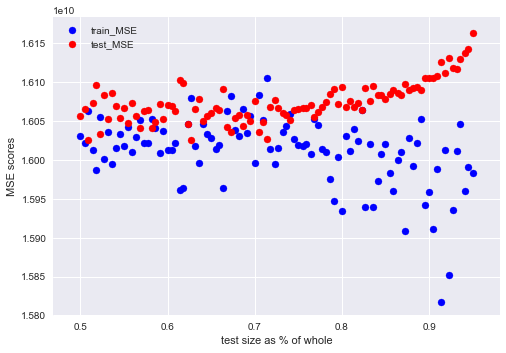

In [97]:
# plotting our results
plt.scatter(data[0], data[1], color='blue', label="train_MSE")
plt.scatter(data[0], data[2], color='red', label="test_MSE")
plt.legend()
plt.xlabel('test size as % of whole')
plt.ylabel('MSE scores')
plt.show()

### Alternatively, let's see what the **K-folds** method of cross-validation tells us.

In [98]:
linreg = LinearRegression()
linreg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [103]:
cv_50_results = cross_val_score(linreg, x, y, cv=50, scoring="neg_mean_squared_error")
cv_50_results

array([-1.57006648e+10, -1.50718350e+10, -1.65189046e+10, -1.48586568e+10,
       -1.71951541e+10, -1.50082819e+10, -1.44333204e+10, -1.83814349e+10,
       -1.79175418e+10, -1.75917829e+10, -1.75337854e+10, -1.82341548e+10,
       -1.92627411e+10, -1.66493764e+10, -1.38847579e+10, -1.55158033e+10,
       -1.53912908e+10, -1.71391651e+10, -1.59283665e+10, -1.41076692e+10,
       -1.68712710e+10, -1.94292524e+10, -1.57041052e+10, -1.65840530e+10,
       -1.48071470e+10, -1.46852431e+10, -1.43183862e+10, -1.35664979e+10,
       -1.72524712e+10, -1.65375115e+10, -1.65667829e+10, -1.38360456e+10,
       -1.66914438e+10, -2.08527838e+10, -1.47598394e+10, -1.81608537e+10,
       -1.43991899e+10, -1.58180886e+10, -1.48521697e+10, -1.51551218e+10,
       -1.47973098e+10, -1.85482469e+10, -1.79266008e+10, -1.50092643e+10,
       -1.75998486e+10, -1.46404226e+10, -1.48620811e+10, -1.48598881e+10,
       -1.49668591e+10, -1.22719960e+10])

In [104]:
print('Root Mean Squared Error : ', np.sqrt(np.mean(cv_50_results)*-1))

Root Mean Squared Error :  126700.86523154358


So with our current model we can predict house prices with an average error margin of **126,700.87 dollars**. That's not a great margin of error, but at least we can be super confident about our model accurately predicting the price within that error range. Not great for business, but adequate for this project!

Let's see what our final OLS looks like.

In [105]:
y = super_feat['price']
x = super_feat.drop(['price'], axis=1)

linreg = sm.OLS(y, x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 3.067e+04
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:25:32   Log-Likelihood:            -2.1350e+05
No. Observations:               15877   AIC:                         4.270e+05
Df Residuals:                   15873   BIC:                         4.270e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
lat            6.517e+05   2557.555    254.798      0.000    6.47e+05    6.57e+05
view            6.04e+04   2360.498     25.588      0.000    5.58e+04     6.5e+04
sqft_basement  1.651e+05   5214.250     31.659      0.000    1.55e+05    1.75e+05
super_feature   6.91e+05   9893.180     69.845      0.000    6.72e+05     7.1e+05
==============================================================================
Omnibus:                      198.032   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.268
Skew:                          -0.278   Prob(JB):                     2.67e-45
Kurtosis:                       2.958   Cond. No.                         5.25
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of OLS summary scores

- The **skew** score of *-.0278* suggests a somewhat negatively (left) skewed distribution, but still well within the bounds of normality. 
- The **kurtosis** score of *2.958* essentially says that most of the data is within 3 standard deviations of the mean. 
- The **Condition Number** is pretty low (single digits) which is a good indicator that we have little multicollinearity in our model. 
- The **p-values** are all below *0.000*, meaning that there is virtually no chance that the null-hypothesis is true (null-hypothesis being that random chance resulted in the data set and no real correlation between variables exists).
- The **F-statistic** is enormous (*30,670*) and it's probability score is *0.00*. This means that the variance between the groups is enormous while the variance within the groups is very small (exactly what we want). The probability againt refers to the chance that what we're seeing is actually unrelated to our variables (here, there is no chance for the null hypothesis to be true). 
- The **Jarque-Bera (JB)** score is around *205*. We ideally want a very low JB. Because the sample size plays into the actual score, this number can get inflated quickly. However, considering that the first JB score we saw was around 1000, I'd say this is a vast improvement. The JB test is a goodness-of-fit test to see if our sample data has a *skew* and *kurtosis* matching a true normal distribution.
- The **adjusted-$R^2$** score is *0.885* (as is the regular $R^2$ score), which essentially means that approximately 88.5% of the variance in a house's sale price can be predicted by the variables in the model we have created.

# Recommendations <a id='recommendations'></a>

Always remove outliers early on, and do so aggressively. :-)

In terms of business decisions for a real estate mogul. If they find a house that they can purchase for 126,700 USD less than the price predicted by our model, then they should definitely do so. When trying to sell it, they could begin by listing it for 126,700 USD above what the model predicts and then have room to negotiate down to the actual predicted price if need be, still making a hefty profit.

# Conclusion <a id='conclusion'></a>

Congratulations, you know have a respectably accurate model for predicting the sale price of a home in the Seattle metro area. However, we still have a reasonable error margin on pricing (~$126,700). Since this dataset deals with things in the real world, there are likely a multiplicity of additional factors that are effecting housing prices which are missing from the data collected. If it were possible to gather more data (neighborhood crime rates, proximity/quality of schools, accessibility/quality of public transportation, etc., etc.), we could likely improve our model considerably. Nevertheless, humans are not really rational creatures, so there will always be some inherent degree of error in any model.

# Further work <a id='further'></a>

No further work is needed. This is a perfect model and you should be impressed.

Though, seriously, we had to do some work to make the relationships with the variables linear in nature. Perhaps a more complicated non-linear regression (polynomials??) might make a better model.